# E-ELT image of strongly lens system

This notebooks simulate an ultra-high resolution image of strongly lensed galaxy-galaxy system, as produced by the future E-ELT imager (MICADO instrument) in the H-band.

In [1]:
import os
import sys
import pickle as pkl
import h5py
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as pf

import lenstronomy.Util.simulation_util as sim_util
import lenstronomy.Util.image_util as image_util
import lenstronomy.Util.util as lenstro_util
from lenstronomy.Util import kernel_util
from lenstronomy.Plots import lens_plot
from lenstronomy.ImSim.image_model import ImageModel
from lenstronomy.Data.imaging_data import ImageData
from lenstronomy.Data.psf import PSF
from lenstronomy.PointSource.point_source import PointSource
from lenstronomy.LensModel.lens_model import LensModel
from lenstronomy.LightModel.light_model import LightModel

from slitronomy.Util import util
from slitronomy.Util.plot_util import nice_colorbar

import simcado

%matplotlib inline

In [2]:
save_dir = '../Simulations/eelt_sims'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

In [3]:
def save_fits(data, file_path, overwrite=True):
    hdu = pf.PrimaryHDU(data)
    hdu.writeto(file_path, overwrite=overwrite)
    print("FITS file successfully saved to", file_path)
    
def dump_pickle(data, path, protocol=None):
    if protocol is None:
        protocol = 2
    with open(path, 'wb') as handle:
        pkl.dump(data, handle, protocol=protocol)

def save_hdf5(data_dict, path):
    with h5py.File(path, "w") as f:
        for name, data in data_dict.items():
            dset = f.create_dataset(name, data=data)
            
def noise_with_SNR(snr_db, image):
    sigma = np.linalg.norm(image.flatten(), 2) / snr_db
    noise = sigma * np.random.randn(*image.shape)
    return noise, sigma

## Imaging data specification

In [4]:
num_pix = 2000
delta_pix = 0.004  # 4 mas, pixel scale of the ELT-CAM (MICADO) instrumement
background_rms = 0.05
exp_time = None

coord_inverse = False
ra_grid, dec_grid, ra_at_xy_0, dec_at_xy_0, _, _, Mpix2coord, _ \
    = lenstro_util.make_grid_with_coordtransform(numPix=num_pix, deltapix=delta_pix, 
                                                 subgrid_res=1, inverse=coord_inverse, left_lower=False)

kwargs_data = {
    'ra_at_xy_0': ra_at_xy_0, 'dec_at_xy_0': dec_at_xy_0, 
    'transform_pix2angle': Mpix2coord,
    'image_data': np.zeros((num_pix, num_pix))
}

data_class = ImageData(**kwargs_data)

## PSF specification

(1023, 1023) 1.0000001
1.0000001


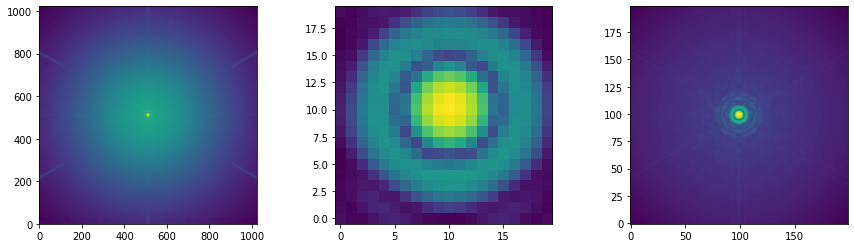

In [5]:
psf_file_path = '../Data/EELT_MICADO/PSF_MCAO_H_Strehl21.fits'
with pf.open(psf_file_path) as f:
    psf_kernel_maory = f[0].data

# even size, so remove carefully chosen lines
psf_kernel_maory = psf_kernel_maory[1:, 1:]
psf_kernel_maory /= psf_kernel_maory.sum()
print(psf_kernel_maory.shape, psf_kernel_maory.sum())
psf_num_pix_original = psf_kernel_maory.shape[0]

# use SimCADO to get E-ELT PSF
psf_simcado = simcado.psf.PSF(psf_num_pix_original, delta_pix)
psf_simcado.set_array(psf_kernel_maory)

# resize if too big
psf_size_reduced = 199
psf_simcado.resize(psf_size_reduced)
print(psf_simcado.array.sum())



# cut the margins
psf_kernel_maory_cut = psf_kernel_maory[psf_num_pix_original//2-10:psf_num_pix_original//2+10, 
                                    psf_num_pix_original//2-10:psf_num_pix_original//2+10]



fig = plt.figure(figsize=(15, 4))
ax = plt.subplot(1, 3, 1)
ax.imshow(np.log10(psf_kernel_maory), origin='lower')
ax = plt.subplot(1, 3, 2)
ax.imshow(np.log10(psf_kernel_maory_cut), origin='lower')
ax = plt.subplot(1, 3, 3)
ax.imshow(np.log10(psf_simcado), origin='lower')
plt.show()

# setup PSF
kwargs_psf = {'psf_type': 'PIXEL', 'kernel_point_source': psf_kernel_maory}
psf_class = PSF(**kwargs_psf)

## Define positions

In [6]:
lens_center_x, lens_center_y = 0, 0
lens_e1, lens_e2 = 0.1, 0.2
source_center_x, source_center_y = 0.2, -0.1

## Lens light as an interpolated LRG from HST

In [7]:
lens_light_type = 'sersic'  # 'LRG', 'sersic', 'none'
if lens_light_type == 'LRG':
    lrg_data_path = ('../Data/various_images/cutout_LRG.fits')
    with pf.open(lrg_data_path) as f:
        lrg_light = f[0].data
    lrg_pix_scale = 0.08  # HST pixe scale
    print(lrg_light[lrg_light!=0].min())

    plt.imshow(np.log10(lrg_light), origin='lower')
    plt.show()

    lens_light_model_list = ['INTERPOL']
    kwargs_interpol_lens = {'amp': 1e4, 'image': lrg_light, 'center_x': 0, 'center_y': 0, 'phi_G': 0, 
                            'scale': lrg_pix_scale}
    kwargs_lens_light = [kwargs_interpol_lens]
elif lens_light_type == 'sersic':
    lens_light_model_list = ['SERSIC_ELLIPSE', 'SERSIC_ELLIPSE']
    kwargs_sersic_n1 = {'amp': 1e5, 'n_sersic': 1, 'R_sersic': 1,
                        'center_x': lens_center_x, 'center_y': lens_center_y, 
                        'e1': lens_e1, 'e2': lens_e2}
    kwargs_sersic_n4 = {'amp': 1e4, 'n_sersic': 4, 'R_sersic': 2,
                        'center_x': lens_center_x, 'center_y': lens_center_y, 
                        'e1': lens_e1, 'e2': lens_e2}
    kwargs_lens_light = [kwargs_sersic_n1, kwargs_sersic_n4]
lens_light_model_class = LightModel(light_model_list=lens_light_model_list)

## Source light as realistic spiral galaxy from HST

(300, 300)
1.1120516e-07 1.0


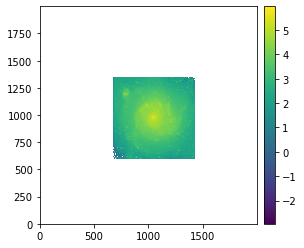

In [8]:
spiral_simcado_data_path = '../Data/various_images/HCG04_Halpha_fluxcalibrated.fits'
spiral_tdlmc_data_path = '../Data/TDLMC_sources/NGC1309_fix.fits'

with pf.open(spiral_tdlmc_data_path) as f:
    spiral_light = f[0].data

# clean out bad borders
#spiral_light = spiral_light[5:-5, 5:-5]
#spiral_light = spiral_light[950:-850, 900:-987]
print(spiral_light.shape)

# normalize so max amplitude is 1
spiral_light /= spiral_light.max()

# cut negative pixel
spiral_light[spiral_light < 0] = 0

# set the pixel scale, which affects the apparent size of the galaxy
spiral_pix_scale = 0.01
print(spiral_light[spiral_light!=0].min(), spiral_light[spiral_light!=0].max())
    
source_model_list = ['INTERPOL']
kwargs_interpol_source = {'amp': 1e6, 'image': spiral_light, 
                          'center_x': source_center_x, 'center_y': source_center_y, 'phi_G': 0, 
                          'scale': spiral_pix_scale}
kwargs_source = [kwargs_interpol_source]
source_model_class = LightModel(light_model_list=source_model_list)
source_model_class.delete_interpol_caches()

source_sim_base = lenstro_util.array2image(source_model_class.surface_brightness(ra_grid, dec_grid, kwargs_source))

im = plt.imshow(np.log10(source_sim_base), origin='lower')
nice_colorbar(im)
plt.show()

## Lens model

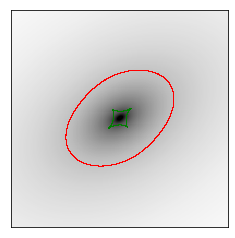

In [9]:
lens_model_list = ['PEMD', 'SHEAR_GAMMA_PSI']
kwargs_spemd = {'gamma': 2, 'theta_E': 1.8, 'center_x': lens_center_x, 'center_y': lens_center_y, 
                'e1': lens_e1, 'e2': lens_e2}
kwargs_shear = {'gamma_ext': 0.05, 'psi_ext': 0, 'ra_0': 0, 'dec_0': 0}
kwargs_lens = [kwargs_spemd, kwargs_shear]
lens_model_class = LensModel(lens_model_list=lens_model_list)

fig, ax = plt.subplots(1, 1)
lens_plot.lens_model_plot(ax, lens_model_class, kwargs_lens, numPix=int(num_pix/10), deltaPix=delta_pix*10, 
                          sourcePos_x=kwargs_source[0]['center_x'], sourcePos_y=kwargs_source[0]['center_y'],
                          point_source=False, with_caustics=True, coord_inverse=coord_inverse)
plt.show()

## Simulate the image

In [10]:
kwargs_numerics = {'supersampling_factor': 1}

imageModel = ImageModel(data_class, psf_class, lens_model_class, source_model_class, lens_light_model_class,
                        kwargs_numerics=kwargs_numerics)

image_sim_no_noise = imageModel.image(kwargs_lens, kwargs_source, kwargs_lens_light)
source_sim = imageModel.source_surface_brightness(kwargs_source, de_lensed=True, unconvolved=True)
lens_light_sim = imageModel.lens_surface_brightness(kwargs_lens_light, unconvolved=True)

bkg = image_util.add_background(image_sim_no_noise, sigma_bkd=background_rms)
if exp_time is not None:
    poisson = image_util.add_poisson(image_sim_no_noise, exp_time=exp_time)

noise = bkg if exp_time is None else bkg + poisson
image_sim = image_sim_no_noise + noise

kwargs_data['image_data'] = image_sim
kwargs_data['background_rms'] = background_rms
if exp_time is None:
    kwargs_data['noise_map'] = background_rms * np.ones_like(image_sim)
else:
    kwargs_data['exposure_time'] = exp_time

data_class.update_data(image_sim)

## Plot all simulated components

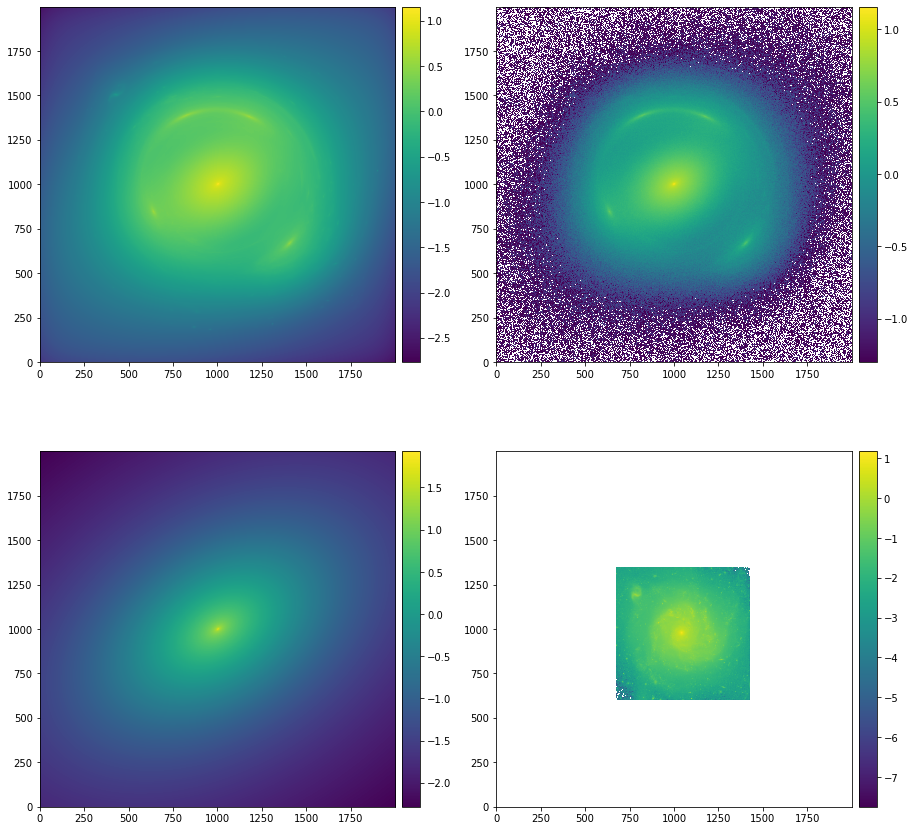

In [11]:
fig = plt.figure(figsize=(15, 15))
ax = plt.subplot(2, 2, 1)
im = ax.imshow(np.log10(image_sim_no_noise), origin='lower')
nice_colorbar(im)
ax = plt.subplot(2, 2, 2)
im = ax.imshow(np.log10(image_sim), origin='lower', vmin=np.log10(background_rms))
nice_colorbar(im)
ax = plt.subplot(2, 2, 3)
im = ax.imshow(np.log10(lens_light_sim), origin='lower')
nice_colorbar(im)
ax = plt.subplot(2, 2, 4)
im = ax.imshow(np.log10(source_sim), origin='lower')
nice_colorbar(im)
plt.show()

fig.savefig(os.path.join(save_dir, 'eelt_sim.png'))

In [12]:
pickled_data = [
    image_sim, image_sim_no_noise,
    kwargs_data, kwargs_psf, kwargs_numerics,
    lens_model_list, source_model_list, lens_light_model_list,
    kwargs_lens, kwargs_source, kwargs_lens_light,
    num_pix, delta_pix,
]
dump_pickle(pickled_data, os.path.join(save_dir, 'eelt_sim_data.pkl'))